In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [4]:
import catboost
print('catboost version:', catboost.__version__)
from catboost import CatBoostClassifier 

catboost version: 1.0.6


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
c_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CFPB_mortgage_BERT/scripts/complaints.csv', encoding='latin-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
c_df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-05-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"EQUIFAX, INC.",TX,77493.0,NaN,NaN,Web,2022-05-23,In progress,Yes,NaN,5589545
1,2022-05-15,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60426.0,NaN,Consent not provided,Web,2022-05-15,Closed with non-monetary relief,Yes,NaN,5563517
2,2022-05-16,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,NaN,NaN,PENTAGON FEDERAL CREDIT UNION,PA,17701.0,NaN,NaN,Web,2022-05-16,In progress,Yes,NaN,5565838


In [9]:
# Column Cleaning First. Columns are super nastily named
c_df.rename(columns={'Date received':'DATE_RECEIVED',
                  'Product':'PRODUCT',
                  'Sub-product':'SUB_PRODUCT',
                  'Issue':'ISSUE',
                  'Sub-issue':'SUB_ISSUE',
                  'Consumer complaint narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'Company public response':'COMPANY_PUBLIC_RESPONSE',
                   'Company':'COMPANY',
                   'State':'STATE',
                   'ZIP code':'ZIP_CODE',
                   'Tags':'TAGS',
                   'Consumer consent provided?':'CONSUMER_CONSENT_PROVIDED',
                   'Submitted via':'SUBMITTED_VIA',
                   'Date sent to company':'DATE_SENT_TO_COMPANY',
                   'Company response to consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'Timely response?':'TIMELY_RESPONSE',
                   'Consumer disputed?':'CONSUMER_DISPUTED',
                   'Complaint ID':'COMPLAINT_ID'
                  }, inplace=True)

In [10]:
c_df.head(2)

,DATE_RECEIVED,PRODUCT,SUB_PRODUCT,ISSUE,SUB_ISSUE,CONSUMER_COMPLAINT_NARRATIVE,COMPANY_PUBLIC_RESPONSE,COMPANY,STATE,ZIP_CODE,TAGS,CONSUMER_CONSENT_PROVIDED,SUBMITTED_VIA,DATE_SENT_TO_COMPANY,COMPANY_RESPONSE_TO_CONSUMER,TIMELY_RESPONSE,CONSUMER_DISPUTED,COMPLAINT_ID
0,2022-05-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"EQUIFAX, INC.",TX,77493.0,NaN,NaN,Web,2022-05-23,In progress,Yes,NaN,5589545
1,2022-05-15,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60426.0,NaN,Consent not provided,Web,2022-05-15,Closed with non-monetary relief,Yes,NaN,5563517


In [11]:
#c_df['Narrative_Value'] = pd.Categorical.from_codes(c_df.CONSUMER_COMPLAINT_NARRATIVE.astype(bool), categories=['not present', 'present'])

#If missing value is empty string
#c_df['Narrative_Value'] = np.where(c_df.CONSUMER_COMPLAINT_NARRATIVE.eq(''), 'Present', 'Not Present')

#If missing value is NaN
c_df['Narrative_Value'] = np.where(c_df['CONSUMER_COMPLAINT_NARRATIVE'].isnull(), 'Not_Present', 'Present')

In [13]:
#If missing value is NaN, create isComplaint_Present field and use numerical values
c_df['isComplaint_Present'] = np.where(c_df['CONSUMER_COMPLAINT_NARRATIVE'].isnull(), 0, 1) # must be integerssince strings show as grey lines on shap figure.

In [14]:
c_df.head(2)

,DATE_RECEIVED,PRODUCT,SUB_PRODUCT,ISSUE,SUB_ISSUE,CONSUMER_COMPLAINT_NARRATIVE,COMPANY_PUBLIC_RESPONSE,COMPANY,STATE,ZIP_CODE,TAGS,CONSUMER_CONSENT_PROVIDED,SUBMITTED_VIA,DATE_SENT_TO_COMPANY,COMPANY_RESPONSE_TO_CONSUMER,TIMELY_RESPONSE,CONSUMER_DISPUTED,COMPLAINT_ID,Narrative_Value,isComplaint_Present
0,2022-05-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"EQUIFAX, INC.",TX,77493.0,NaN,NaN,Web,2022-05-23,In progress,Yes,NaN,5589545,Not_Present,0
1,2022-05-15,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60426.0,NaN,Consent not provided,Web,2022-05-15,Closed with non-monetary relief,Yes,NaN,5563517,Not_Present,0


In [15]:
 # create isfemale field and use numerical values

c_df['isComplaintpresent'] = np.where(c_df['Narrative_Value'] == 'Present', 1, 0)

In [16]:
# drop features not needed for model 
c_df = c_df[[f for f in list(c_df) if f not in ['ISSUE', 'SUB_ISSUE', 'COMPANY', 'STATE', 'Narrative_Value', 'COMPLAINT_ID', 'isComplaintpresent','ZIP_CODE', 'CONSUMER_COMPLAINT_NARRATIVE', 'COMPANY_PUBLIC_RESPONSE', 'CONSUMER_CONSENT_PROVIDED']]]

In [17]:
# Pre-drop category value_counts
c_df.COMPANY_RESPONSE_TO_CONSUMER.value_counts()

Closed with explanation            2153989
Closed with non-monetary relief     325850
Closed with monetary relief         114845
In progress                          43705
Closed without relief                17868
Closed                               17611
Untimely response                     9160
Closed with relief                    5304
Name: COMPANY_RESPONSE_TO_CONSUMER, dtype: int64

In [18]:
# Dropping rows with the aggregated columns
c_df.drop(
    c_df[
    c_df.COMPANY_RESPONSE_TO_CONSUMER == 
    'In progress'].index, 
    inplace=True) # In progress  

c_df.drop(
    c_df[
    c_df.COMPANY_RESPONSE_TO_CONSUMER == 
    'Closed'].index, 
    inplace=True) # Closed  

c_df.drop(
    c_df[
    c_df.COMPANY_RESPONSE_TO_CONSUMER == 
    'Untimely response'].index, 
    inplace=True) # Untimely response

c_df.drop(
    c_df[
    c_df.COMPANY_RESPONSE_TO_CONSUMER == 
    'Closed with explanation'].index, 
    inplace=True) # Closed with explanation

In [19]:
# Pre-drop category value_counts
c_df.COMPANY_RESPONSE_TO_CONSUMER.value_counts()

Closed with non-monetary relief    325850
Closed with monetary relief        114845
Closed without relief               17868
Closed with relief                   5304
Name: COMPANY_RESPONSE_TO_CONSUMER, dtype: int64

In [20]:
c_df.drop(
    c_df[
    c_df.COMPANY_RESPONSE_TO_CONSUMER == 
    'Closed with relief'].index, 
    inplace=True) # Closed with explanation

In [21]:
c_df.drop(
    c_df[
    c_df.COMPANY_RESPONSE_TO_CONSUMER == 
    'Closed without relief'].index, 
    inplace=True) # Untimely response

In [22]:
# Pre-drop category value_counts
c_df.COMPANY_RESPONSE_TO_CONSUMER.value_counts()

Closed with non-monetary relief    325850
Closed with monetary relief        114845
Name: COMPANY_RESPONSE_TO_CONSUMER, dtype: int64

In [23]:


#make pclass actual categorical column
#c_df['COMPANY_RESPONSE_TO_CONSUMER'] = np.where(c_df['COMPANY_RESPONSE_TO_CONSUMER'] == 'Closed with non-monetary relief', c_df['COMPANY_RESPONSE_TO_CONSUMER'], 0) 
#c_df['COMPANY_RESPONSE_TO_CONSUMER'] = np.where(c_df['COMPANY_RESPONSE_TO_CONSUMER'] == 'Closed with monetary relief', c_df['COMPANY_RESPONSE_TO_CONSUMER'], 1 )
#c_df['COMPANY_RESPONSE_TO_CONSUMER'] = np.where(c_df['COMPANY_RESPONSE_TO_CONSUMER'] == 'Closed without relief', c_df['COMPANY_RESPONSE_TO_CONSUMER'], 2 )

c_df['company_response'] = np.where(c_df['COMPANY_RESPONSE_TO_CONSUMER'] == 'Closed with monetary relief', 1, 0)

#c_df['CONSUMER_DISPUTED'] = c_df['CONSUMER_DISPUTED'].replace(np.NaN, 'Unknown') 

#c_df['TAGS'] = c_df['TAGS'].replace(np.NaN, 'Unknown') 


In [24]:
c_df.head(2)

,DATE_RECEIVED,PRODUCT,SUB_PRODUCT,TAGS,SUBMITTED_VIA,DATE_SENT_TO_COMPANY,COMPANY_RESPONSE_TO_CONSUMER,TIMELY_RESPONSE,CONSUMER_DISPUTED,isComplaint_Present,company_response
1,2022-05-15,"Credit reporting, credit repair services, or o...",Credit reporting,NaN,Web,2022-05-15,Closed with non-monetary relief,Yes,NaN,0,0
4,2022-05-14,"Credit reporting, credit repair services, or o...",Credit reporting,NaN,Web,2022-05-14,Closed with non-monetary relief,Yes,NaN,0,0


In [25]:
# Pre-drop category value_counts
c_df.company_response.value_counts()

0    325853
1    114845
Name: company_response, dtype: int64

In [26]:
# Pre-drop category value_counts
c_df.PRODUCT.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    170041
Debt collection                                                                  56015
Credit card or prepaid card                                                      39636
Credit reporting                                                                 39606
Mortgage                                                                         28787
Checking or savings account                                                      28189
Credit card                                                                      27938
Bank account or service                                                          23517
Student loan                                                                      6862
Money transfer, virtual currency, or money service                                6237
Consumer Loan                                                                     4777
Vehicle loan or lease                      

In [27]:
# replacing values
c_df['PRODUCT'].replace(['Credit reporting, credit repair services, or other personal consumer reports', 
                         'Debt collection',
                         'Credit card or prepaid card',
                         'Credit reporting',
                         'Mortgage',
                         'Checking or savings account',
                         'Credit card ',
                         'Bank account or service',
                         'Student loan',
                         'Money transfer, virtual currency, or money service',
                         'Consumer Loan',
                         'Vehicle loan or lease',
                         'Payday loan, title loan, or personal loan',
                         'Prepaid card',
                         'Money transfers',
                         'Payday loan',
                         'Other financial service'],
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], inplace=True)

In [30]:
# Pre-drop category value_counts
c_df.SUBMITTED_VIA.value_counts()

Web             360122
Referral         40588
Phone            21245
Postal mail      14834
Fax               3828
Email               58
Web Referral        23
Name: SUBMITTED_VIA, dtype: int64

In [31]:
# replacing values
c_df['SUBMITTED_VIA'].replace(['Web','Referral','Phone' ,'Postal mail', 'Fax', 'Email','Web Referral'],
                        [0, 1, 2, 3, 4, 5, 6], inplace=True)

In [34]:
# Pre-drop category value_counts
c_df.TIMELY_RESPONSE.value_counts()

Yes    436578
No       4120
Name: TIMELY_RESPONSE, dtype: int64

In [35]:
# replacing values
c_df['TIMELY_RESPONSE'].replace(['Yes','No'],
                        [0, 1], inplace=True)

In [53]:
c_df['CONSUMER_DISPUTED'] = c_df['CONSUMER_DISPUTED'].replace(np.NaN, 'Unknown') 


c_df['PRODUCT'] = c_df['PRODUCT'].replace(np.NaN, 'Unknown')




c_df['SUBMITTED_VIA'] = c_df['SUBMITTED_VIA'].replace(np.NaN, 'Unknown')



In [54]:
# Pre-drop category value_counts
c_df.CONSUMER_DISPUTED.value_counts()

Unknown    293885
2          130276
1           16537
Name: CONSUMER_DISPUTED, dtype: int64

In [55]:
# replacing values
c_df['CONSUMER_DISPUTED'].replace(['unknown','Yes','No'],
                        [3, 1, 2], inplace=True)

In [56]:
c_df.head(3)

,PRODUCT,SUBMITTED_VIA,CONSUMER_DISPUTED,isComplaint_Present,company_response
1,0,0,Unknown,0,0
4,0,0,Unknown,0,0
7,0,0,Unknown,0,0


In [57]:
# drop features not needed for model 
c_df = c_df[[f for f in list(c_df) if f not in [ 'DATE_RECEIVED', 'DATE_SENT_TO_COMPANY', 'TAGS', 'SUB_ISSUE', 'SUB_PRODUCT', 'TIMELY_RESPONSE', 'COMPANY_RESPONSE_TO_CONSUMER']]]

In [58]:
# map categorical features
c_catboost_ready_df = c_df.dropna() 

features = [feat for feat in list(c_catboost_ready_df) 
            if feat != 'company_response']
print(features)

['PRODUCT', 'SUBMITTED_VIA', 'CONSUMER_DISPUTED', 'isComplaint_Present']


In [59]:

categorical_features = np.where(c_catboost_ready_df[features].dtypes != np.float)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [60]:
print(categorical_features)

[0 1 2 3]


In [61]:
# map categorical features
c_catboost_ready_df = c_df.dropna() 

features = [feat for feat in list(c_catboost_ready_df) 
            if feat != 'company_response']
print(features)
categorical_features = np.where(c_catboost_ready_df[features].dtypes != np.float)[0]
 

['PRODUCT', 'SUBMITTED_VIA', 'CONSUMER_DISPUTED', 'isComplaint_Present']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [62]:
X_train, X_test, y_train, y_test = train_test_split(c_df[features], 
                                                    c_df[['company_response']], 
                                                    test_size=0.3, 
                                                    random_state=1)

In [63]:
 
params = {'iterations':5000,
        'learning_rate':0.01,
        'cat_features':categorical_features,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 1
          }

In [64]:
cat_model = CatBoostClassifier(**params)

In [65]:
# True if we don't want to save trees created after iteration with the best validation score
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8947583	best: 0.8947583 (0)	total: 346ms	remaining: 28m 47s
200:	test: 0.9149302	best: 0.9149305 (196)	total: 36.4s	remaining: 14m 29s
400:	test: 0.9150771	best: 0.9150831 (244)	total: 1m 13s	remaining: 13m 58s
600:	test: 0.9152138	best: 0.9152193 (572)	total: 1m 51s	remaining: 13m 36s
800:	test: 0.9153276	best: 0.9153277 (796)	total: 2m 29s	remaining: 13m 2s
1000:	test: 0.9154086	best: 0.9154092 (981)	total: 3m 8s	remaining: 12m 32s
1200:	test: 0.9154555	best: 0.9154578 (1152)	total: 3m 50s	remaining: 12m 8s
1400:	test: 0.9154926	best: 0.9154927 (1387)	total: 4m 32s	remaining: 11m 40s
1600:	test: 0.9154920	best: 0.9154959 (1578)	total: 5m 12s	remaining: 11m 3s
1800:	test: 0.9155063	best: 0.9155070 (1793)	total: 5m 56s	remaining: 10m 32s
2000:	test: 0.9155230	best: 0.9155233 (1993)	total: 6m 40s	remaining: 10m
2200:	test: 0.9155588	best: 0.9155616 (2174)	total: 7m 25s	remaining: 9m 26s
2400:	test: 0.9156299	best: 0.9156306 (2395)	total: 8m 9s	remaining: 8m 50s
2600:	test: 0.

In [66]:
!pip install shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.3 MB/s 


In [69]:
import shap  # package used to calculate Shap values

# SHapley Additive exPlanations
# The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. 

from catboost import CatBoostClassifier, Pool
shap_values = cat_model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features) ,
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])
#plt.savefig('/content/drive/My Drive/Colab Notebooks/CFPB_mortgage_BERT/scripts/scratch.png')

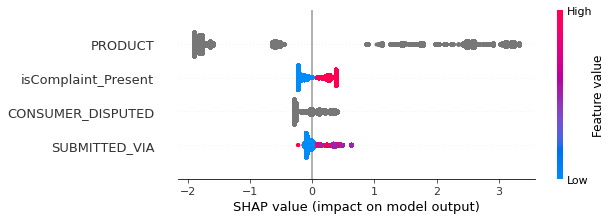

In [70]:
shap.summary_plot(shap_values, X_test) 

That is if the compleint narrative is present  is considered a more important feature (seen in red)  for prediction if the oragnization response is 'closed with monetary relief' or closed with non-monetary relief'.

On the contray, absence of complaint narrative is a less important feature (seen in blue for organizational response prediction.

Hence, I will go ahead and use the textual consumer complaint narrative to predict organization resposne.